<a name="lib"></a>

# 1. Import libraries and packages

Import the libraries and packages that are needed to run this file:

In [ ]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


In [ ]:
# For retrieving data
import yfinance as yf

from datetime import datetime, timedelta

# 2. Import Dataset

## 2.1 Define Dataset Datatime

Define the starting time to recent time to get the data from yfinance:

In [ ]:
START = "2015-01-01"
TODAY = datetime.today().strftime("%Y-%m-%d")

Downloading dataset from BBCA.JK with 1 day interval using yfinance:

In [ ]:
data = yf.download(tickers="BBCA.JK", start=START, end=TODAY, interval='1d')

[*********************100%***********************]  1 of 1 completed


## 2.3 Data Exploration

In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-14,8600.0,8700.0,8525.0,8625.0,8625.0,118164300
2022-12-15,8575.0,8600.0,8500.0,8500.0,8500.0,113255700
2022-12-16,8425.0,8650.0,8400.0,8600.0,8600.0,181516700
2022-12-19,8650.0,8700.0,8600.0,8650.0,8650.0,67482900
2022-12-20,8550.0,8650.0,8550.0,8575.0,8575.0,41243700


## 2.4 Make a copy of a dataset

In [ ]:
maindf = data.copy()

## 2.5 Reset Index

Reseting index from the dataset because the default index determined as date column which is going to be used:

In [ ]:
maindf.reset_index(inplace=True)

## 2.6 Renaming the columns names

In [ ]:
maindf = maindf.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                 'Adj Close':'adj_close','Volume':'volume'})

In [ ]:
maindf.head()

,date,open,high,low,close,adj_close,volume
0,2015-01-02,2655.0,2655.0,2630.0,2645.0,2358.199463,29302500
1,2015-01-05,2630.0,2640.0,2625.0,2640.0,2353.741211,25434500
2,2015-01-06,2600.0,2640.0,2600.0,2620.0,2335.909912,48681500
3,2015-01-07,2610.0,2640.0,2610.0,2625.0,2340.368164,40334000
4,2015-01-08,2625.0,2630.0,2595.0,2595.0,2313.621094,54457000


## 2.7 Counting the total numbers of days and fields:

In [ ]:
print("Total number of days: ",maindf.shape[0])
print("Total number of fields: ",maindf.shape[1])

Total number of days:  1991
Total number of fields:  7


counting the total number of days from the data which shows 1991 days in total, and the the data also has 7 columns in total.

<a name="na"></a>

## 2.8 Checking Null and NA value

In [ ]:
print("Null values:", maindf.isnull().values.sum())
print("NA values:", maindf.isna().values.any())

Null values: 0
NA values: False


no null value found

<a name="predate"></a>

## 2.9 Convert Date field into datetime format

In [ ]:
# convert date field from string to Date format 
maindf['date'] = pd.to_datetime(maindf.date)
maindf.head()

,date,open,high,low,close,adj_close,volume
0,2015-01-02,2655.0,2655.0,2630.0,2645.0,2358.199463,29302500
1,2015-01-05,2630.0,2640.0,2625.0,2640.0,2353.741211,25434500
2,2015-01-06,2600.0,2640.0,2600.0,2620.0,2335.909912,48681500
3,2015-01-07,2610.0,2640.0,2610.0,2625.0,2340.368164,40334000
4,2015-01-08,2625.0,2630.0,2595.0,2595.0,2313.621094,54457000


changing the `date` column data type to datetime, as it's an object before.

<a name="eda"></a>

# 3. EDA (Exploratory Data Analysis)

<a name="dur"></a>

## 3.1 Find the duration of dataset

In [ ]:
print("Starting date: ",maindf.iloc[0][0])
print("Ending date: ", maindf.iloc[-1][0])
print("Duration: ", maindf.iloc[-1][0]-maindf.iloc[0][0])

Starting date:  2015-01-02 00:00:00
Ending date:  2022-12-20 00:00:00
Duration:  2909 days 00:00:00


the data starts from 2015 until at the end of 2022 with the total in days is 2909 days.

<a name="oc"></a>

## 3.2 Monthwise comparision between Stock open and close price

In [ ]:
monthvise= maindf.groupby(maindf['date'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,open,close
date,,
January,4955.610465,4953.197674
February,4983.653846,4976.602564
March,4896.734104,4881.300578
April,4826.951220,4817.652439
May,4634.281046,4636.437908
June,4809.289941,4807.130178
July,5003.666667,5006.818182
August,5068.852941,5078.735294
September,5158.823529,5164.147059


comparing the average price of open and close stock per month:

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price')
fig.show()

November has the highest average number of open and close stock price, meanwhile May has the least average number of the open and close stock price.

<a name="hl"></a>

## 3.3 Monthwise High and Low stock price 

In [ ]:
maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_high = maindf.groupby(maindf['date'].dt.strftime('%B'))['high'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = maindf.groupby(maindf['date'].dt.strftime('%B'))['low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low stock price')
fig.show()

From the max and min value based on stock prices, November has the highest price which is 9400, compared to other months. meanwhile, August has the lowest price which is 2200 compared to other months.

<a name="trend"></a>

## 3.4 Trend comparision between stock open price, close price, high price, low price

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(maindf, x=maindf.date, y=[maindf['open'], maindf['close'], 
                                          maindf['high'], maindf['low']],
             labels={'date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

From the overall trend comparinson between open, close, high, and low stock prices, it can be seen that on February 2020 there is a significant decrease compared to other month or years.

<a name="sc"></a>

**Here, We are going to predict close price for next 30 days**

## 3.5 Prepare Stock Close price

<a name="df"></a>

### 3.5.1 Make separate dataframe of close price

In [ ]:
closedf = maindf[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1991, 2)


For the next analysis step, we only used `date` and `close` columns for modeling.

<a name="pclose"></a>

### 3.5.2 Plotting Stock Close price chart

In [ ]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

From the stock close price plot above, it can be seen that there is a significant decreasing on February 2020.

<a name="year"></a>

### 3.5.3 Consider only last 1 year data for prediction

In [ ]:
closedf = closedf[closedf['date'] > '2021-12-16']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  248


The total number of data used for analysis to do the prediction is 248 data which is for the last 1 year.

The graphic below represent the stock close price for the last 1 year:

In [ ]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# 4. Data Pre-Processing

<a name="norm"></a>

## 4.1 Normalizing close price

Normalizing the data with range 0 until 1 and add 1 more dimension:

In [ ]:
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(248, 1)


<a name="split"></a>

## 4.2 Prepare Data for train and test

after the normalization, the data is divided into 2 data-set which are train-set and test-set. but the divide must be ordered, or can't be done separately:

In [ ]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (148, 1)
test_data:  (100, 1)


<a name="trans"></a>

## 4.3 Transform Close price base on Time-series-analysis forecasting requirement

This function is to create new dataset based on customs time step:

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
create_dataset

<function __main__.create_dataset(dataset, time_step=1)>

Because we want to predict using the last 1 week patterns, we're using 8 time step:

In [ ]:
time_step = 8
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (139, 8)
y_train:  (139,)
X_test:  (91, 8)
y_test (91,)


Add one more dimension to make it become 3 dimension to fulfill the terms of LSTM model:

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (139, 8, 1)
X_test:  (91, 8, 1)


# 5. Model Building (LSTM)

## 5.1 Defining the model

I'm using LSTM model with adam as the optimizer and MSE as the loss function:

In [ ]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

## 5.2 Model Summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 8, 32)             8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


The total number of params used to do the model training is 21.025 params.

## 5.3 Model Training

Training the model with 500 epoch which means the training is done 500 times with validation data set that is splitted before.

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=500,batch_size=32,verbose=1)

<a name="loss"></a>

### 5.4 Plotting loss chart

Visualize the loss training result with the validation loss.

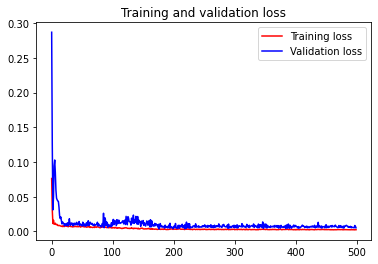

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

Based on the plot above, the result of model training is good enough because there is no exploding gradient or vanishing gradient. And the model can be considered as bestfit because the difference between training and validation loss is really small.

## 5.5 Performance Metrics

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

3/3 [==============================] - 0s 6ms/step


((139, 1), (91, 1))

<a name="eval"></a>

# 6. Model Evaluation

## 6.1 Inverse Transform

Before model evaluation, we were doing inverse transform to make it go back to the base value (value before) :

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

<a name="mse"></a>

## 6.2 Evaluation metrices RMSE, MSE and MAE

To evaluate errors, I'm using Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE). This is a standard way to measure the error of a model in predicting quantitative data.

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  111.86077079065451
Train data MSE:  12512.832041879346
Train data MAE:  88.09136479878595
-------------------------------------------------------------------------------------
Test data RMSE:  166.12825784597354
Test data MSE:  27598.598054938266
Test data MAE:  125.5822029532967


<a name="var"></a>

## 6.3 Explained variance regression score


The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [ ]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.851944261663712
Test data explained variance regression score: 0.8016346093031119


<a name="r2"></a>

## 6.4 R<sup>2</sup> score for regression

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.
<br>
R<sup>2</sup> ranges from 0 to 1.
<br>
The higher the R<sup>2</sup> value, the better the model is able to predict the outcome based on the input variables. 
<br>
1 = Best <br>
0 or < 0 = worst

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.8463745136422756
Test data R2 score: 0.7028002717938027


From the r2-score shown above, it is seen that the model is good enough with 0.85 train score, and 0.7 test score.

<a name="cp"></a>

# 6.5 Comparison of original stock close price and predicted close price

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (248, 1)
Test predicted data:  (248, 1)


From the comparison between original close price and predicted close price plot above, we can tell that there's almost no significant difference which shows that the accuracy between original and predicted close price is good enough.

# 7. Predicting

<a name="days"></a>

## 7.1 Predicting next 30 days

the next step is predicting the close price for the next 30 days using the last 7 days data as the reference pattern:

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

1 day input [0.73913043 0.73913043 0.70652174 0.65217391 0.69565217 0.7173913
 0.68478261 0.64886683]
1 day output [[0.6176815]]
[0.7391304347826084, 0.7391304347826084, 0.7065217391304346, 0.652173913043478, 0.6956521739130435, 0.7173913043478262, 0.6847826086956523, 0.6488668322563171, 0.6176815032958984]
2 day input [0.73913043 0.70652174 0.65217391 0.69565217 0.7173913  0.68478261
 0.64886683 0.6176815 ]
2 day output [[0.59181726]]
[0.7391304347826084, 0.7065217391304346, 0.652173913043478, 0.6956521739130435, 0.7173913043478262, 0.6847826086956523, 0.6488668322563171, 0.6176815032958984, 0.5918172597885132]
3 day input [0.70652174 0.65217391 0.69565217 0.7173913  0.68478261 0.64886683
 0.6176815  0.59181726]
3 day output [[0.5763425]]
[0.7065217391304346, 0.652173913043478, 0.6956521739130435, 0.7173913043478262, 0.6847826086956523, 0.6488668322563171, 0.6176815032958984, 0.5918172597885132, 0.5763425230979919]
4 day input [0.65217391 0.69565217 0.7173913  0.68478261 0.64886683 0.

<a name="pdays"></a>

## 7.2 Plotting last 7 days of dataset and next predicted 30 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[1 2 3 4 5 6 7 8]
[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 7 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 7 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

The plot above shows the model prediction for the next 30 days, and there is a downtrend.

<a name="pwhole"></a>

## 7.3 Plotting entire Closing Stock Price with next 30 days period of prediction 

Visualizing the overall close stock price with the predicition result.

In [ ]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# 8. SAVE MODEL

Saving the model used for deployment with the preprocessing step which is scaler.

In [ ]:
model.save('model_bca.h5')

In [ ]:
import pickle
with open("scaler_bca.pkl", "wb") as f:
    pickle.dump(scaler, f)